#### A character-level autocompletion model with a simple RNN using Keras and TensorFlow

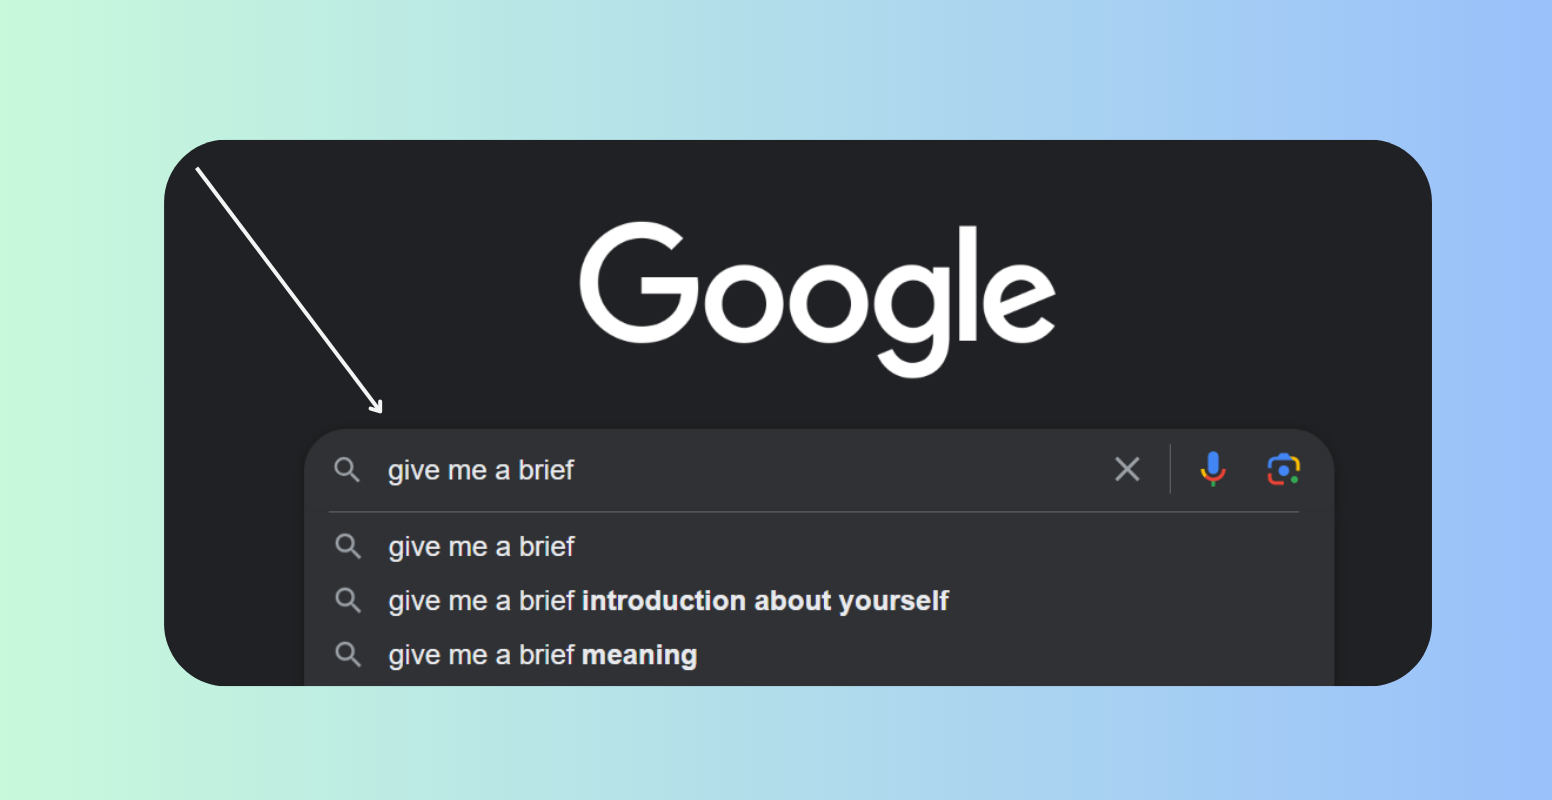

`Recurrent neural networks (RNNs)` are powerful tools for generating text because they can learn the `patterns` and `sequences` present in human language.

Unlike regular neural networks, `RNNs` have an `internal memory` that allows them to consider past inputs when processing current ones. This is crucial for text generation, where the meaning of a word depends on the words before it.

<hr>

<hr>

#### Setting up the Environment

In [ ]:
# install the necessary packages within the virtual env
!pip install --upgrade keras
!python3 -m pip install tensorflow
!pip install pandas

<hr>

#### Import the necessary packages

In [34]:
# import the necessary packages (note: here we are using the TensorFlow backend)
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Input, Dense, Activation

import numpy as np
import pandas as pd
import os

In [2]:
# define Global variables

DATA_DIR = os.path.join(os.getcwd(),'Data')

<hr>

#### Data cleaning and pre-processing

In [3]:
# Preview the raw data
print("Raw data previw (first 1000 characters...")
file = open(os.path.join(DATA_DIR,"wonderland.txt"), 'rb')
lines = []
for line in file:
    # remove extra spaces and covert the text to lowercase
    line = line.strip().lower()
    # converting a byte sequence (line) into a text string using ASCII encoding
    line = line.decode("ascii", "ignore")
    if len(line) == 0:
        continue
    lines.append(line)
file.close()


text = " ".join(lines)
print(text[:1000])

Raw data previw (first 1000 characters...
project gutenbergs alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  you may copy it, give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org title: alices adventures in wonderland author: lewis carroll posting date: june 25, 2008 [ebook #11] release date: march, 1994 last updated: october 6, 2016 language: english character set encoding: utf-8 *** start of this project gutenberg ebook alices adventures in wonderland *** alices adventures in wonderland lewis carroll the millennium fulcrum edition 3.0 chapter i. down the rabbit-hole alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, and what is the use of a 

For more informations about the book used as data: [data](https://www.adobe.com/be_en/active-use/pdf/Alice_in_Wonderland.pdf)

In [4]:
# The goal is to complete the next character given the previous state and the current input (character-level autocompletion)

# Extact the set of characters (a set holds non-repetitive elements)

chars = set([c for c in text])
print('the unique characters within our dataset are:', chars)
print('*'*30)
nb_chars = len(chars)
print('the number of features(unique characters) in our dataset is', nb_chars)

# what about the total number of caracters in our dataset
print('*'*30)
print("The total number of caracters in our dataset is:",len([c for c in text]))

# create a char2index and vice verca tables (for referencing)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

the unique characters within our dataset are: {'#', '_', 'w', 'x', 'a', 'j', 'd', '3', '%', '1', ',', '!', '$', 'e', 'y', '2', '-', '/', '0', '(', 'l', 'r', ']', 'h', 'o', 'f', 'g', 'v', '8', 'b', 'm', ';', '7', '4', ' ', 'c', 'u', 'n', 's', '.', '?', ')', '9', 't', 'z', 'i', '5', 'p', '@', '6', 'k', ':', '*', '[', 'q'}
******************************
the number of features(unique characters) in our dataset is 55
******************************
The total number of caracters in our dataset is: 158783


In [5]:
# run this example to understand the process in depth
txt = "hello I am ismail"
print('the length of text is:',len(txt))

wd_size = 5
for i in range(0, 17-wd_size, 1):
    print("input:", txt[i:i + wd_size])
    print('label', txt[i+wd_size])

the length of text is: 17
input: hello
label  
input: ello 
label I
input: llo I
label  
input: lo I 
label a
input: o I a
label m
input:  I am
label  
input: I am 
label i
input:  am i
label s
input: am is
label m
input: m ism
label a
input:  isma
label i
input: ismai
label l


<hr>

In [6]:
# Preparing the inputs and labels

SEQLEN = 10 # the sequence length to take at a time (also called window_size or the number of characters to consider as input)
STEP = 1 # step one character at a time
## example: 
##  first sample: I am Ismai -> l
##  second sample: am Ismail -> o ..etc
# inputs and labels
input_chars = []
label_chars = []

# loop through each sequence, take the input sequence and output sequence(labels) [ the len(text) - SEQLEN is used to ensure inbound selection ]
for i in range(0, len(text) - SEQLEN, STEP):
    # take the input sequence of length SEQLEN
    input_chars.append(text[i:i + SEQLEN])
    # take the ramaining character as label (remember that a list slicing take the final provided index-1)
    label_chars.append(text[i + SEQLEN])

In [7]:
# let's review the raw data
text[:100]

'project gutenbergs alices adventures in wonderland, by lewis carroll this ebook is for the use of an'

In [8]:
# Preview data
data_frame = pd.DataFrame(columns=['input','label'])
data_frame['input'] = input_chars
data_frame['label'] = label_chars
    
data_frame.head()

,input,label
0,project gu,t
1,roject gut,e
2,oject gute,n
3,ject guten,b
4,ect gutenb,e


In [9]:
# Vectorize the data

# Our features will be one-hot encoded, shape of X after one-hot encoding= (number of elements, number of rows, number of columns-features(unique chars)) (check X.shape)
X = np.zeros((len(input_chars), SEQLEN, nb_chars)) # (158773, 10, 55) each of the 158773 characters have 10 lines and their correspondence is set against the features nb_chars
y = np.zeros((len(input_chars), nb_chars))
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        # encode the indexed character only (for each one input_char from input_char[s])
        X[i, j, char2index[ch]] = 1
     # encode the index character only   
    y[i, char2index[label_chars[i]]] = 1

<hr>

In [ ]:
# To more illustrate what we have done, review the below example
for i, input_char in enumerate(input_chars):
    print('i',i,'------',input_char)
    print('-----------')
    for j, ch in enumerate(input_char):
        print('j:',j,'------',ch)
    break

<hr>

In [10]:
# The shape of X is
X.shape

(158773, 10, 55)

In [11]:
# The shape of y is
y.shape

(158773, 55)

In [12]:
# preview (the y-encoded output label)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 55)
prev = pd.DataFrame(data=y, index= label_chars)
prev.columns = chars
prev.tail(100)

,#,_,w,x,a,j,d,3,%,1,",",!,$,e,y,2,-,/,0,(,l,r,],h,o,f,g,v,8,b,m,;,7,4,,c,u,n,s,.,?,),9,t,z,i,5,p,@,6,k,:,*,[,q
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
o,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr>

#### Building the RNN model

In [36]:
# Define hyperparameters
RNN_HIDDEN_DIM = 128  # This defines the dimensionality of the hidden layer in the RNN. 
                         # Higher values can improve model complexity but also risk overfitting.

BATCH_SIZE = 128        # This defines the number of samples used to update the model weights at each iteration. 
                         # A balance between memory usage and efficiency is necessary here.

NUM_ITERATIONS = 25     # This defines the total number of training cycles the model will go through.

NUM_EPOCHS_PER_ITERATION = 1  # This defines the number of times the entire dataset is passed through the model 
                             # within a single iteration. More epochs can improve accuracy but risk overfitting.

NUM_PREDS_PER_EPOCH = 100  # This defines the number of predictions generated after each epoch for monitoring purposes.

# Using sequential API
model = Sequential()

# Define the input layer explicitly
inputs = Input(shape=X[0].shape)

model.add(SimpleRNN(RNN_HIDDEN_DIM, return_sequences=False,
                    activation='relu',
                    unroll=True))  # This adds a SimpleRNN layer with the specified hidden dimension, 
                                    # returning the final output only (return_sequences=False), 
                                    # using the ReLU activation function, 
                                    # and unrolling the loop for efficiency (unroll=True). 

# Adding a fully connected layer with nb_chars as number of neurons
model.add(Dense(nb_chars))  # This adds a fully connected (Dense) layer with a number of neurons equal to nb_chars

# This adds a layer with the softmax activation function
model.add(Activation("softmax"))  

model.compile(loss="categorical_crossentropy", optimizer="adam")  # This compiles the model using the categorical crossentropy loss function 
                                                                   # (suitable for multi-class classification) and the Adam optimizer.


In [37]:
# model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# start the training
for iteration in range(NUM_ITERATIONS):
    print("-" * 50)
    # print the current iteration
    print("Iteration #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

--------------------------------------------------
Iteration #: 0
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2.6610
--------------------------------------------------
Iteration #: 1
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.0223
--------------------------------------------------
Iteration #: 2
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.8395
--------------------------------------------------
Iteration #: 3
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.7391
--------------------------------------------------
Iteration #: 4
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.6655
--------------------------------------------------
Iteration #: 5
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.6109
--------------------------------------------------
Iteration #: 6
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.5742
--------------------------------------------------
Iteration #: 7
1241/1241 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.5414
-------

<hr>

#### Testing the model (qualitative evaluation)

In [41]:
# randomly choose a row from input_chars, then use it to 
# generate text using our model for the next 100 chars [providing a starting point for text generation]
test_idx = np.random.randint(len(input_chars))
test_chars = input_chars[test_idx]
print("Generating from seed: %s" % (test_chars))
print(test_chars, end="")

# A loopt to generate 100 characters [NUM_PREDS_PER_EPOCH = 100 & one char is generated per iteration]
for i in range(NUM_PREDS_PER_EPOCH):
    # For each sequence do the same process
    Xtest = np.zeros((1, SEQLEN, nb_chars))
    # Re-encode it using the same strategy (based on the test_chars indication)
    for i, ch in enumerate(test_chars):
        Xtest[0, i, char2index[ch]] = 1
    pred = model.predict(Xtest, verbose=0)[0]
    # take the argmax from the softmax's output (high probability & index2char for character mapping based on the provided index) 
    ypred = index2char[np.argmax(pred)]
    print(ypred, end="")
    # move forward with test_chars + ypred (to re generate another input sequence and continue the same steps)
    test_chars = test_chars[1:] + ypred
print()

Generating from seed:  but it wa
 but it was a long the seching offen the permenting the see it was a long the seching offen the permenting the


In [51]:
# Let's get the same senctence from the original text and compare it with the generated one
original_text = text[test_idx:test_idx+NUM_PREDS_PER_EPOCH+1]
original_text

' but it was all dark overhead; before her was another long passage, and the white rabbit was still in'

<hr>

#### Conclusion:



**As we can see comparing the original text with the newly generated one,
The model needs further improvements**

<hr>

#### Long Short Term Memory (LSTM)